In [4]:
!uv pip install jupyterlab-vim

Using Python 3.12.3 environment at: C:\Users\RBO\repos\masknmf-toolbox\.venv
Audited 1 package in 12ms


In [5]:
## juperlab is annoying if you dont have the correct working version
!uv pip list | grep jupyterlab

jupyterlab                    4.4.2
jupyterlab-pygments           0.3.0
jupyterlab-server             2.27.3
jupyterlab-vim                4.1.4
jupyterlab-widgets            3.0.15


Using Python 3.12.3 environment at: C:\Users\RBO\repos\masknmf-toolbox\.venv


In [6]:
from pathlib import Path
import fastplotlib as fpl
import os
import sys
import masknmf
import tifffile
import torch
import numpy as np

import matplotlib.pyplot as plt
import time
%matplotlib inline
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load in a raw suite2p binary: `data.bin`

- the ops.npy file contains the keys 'nframes', 'Lx' and 'Ly', used to reshape the data

In [7]:
reg_file = Path(r"D:\demo\suite2p_results\plane1\data.bin")
raw_file = Path(r"D:\demo\suite2p_results\plane1\data_raw.bin")
ops = np.load(Path(r"D:\demo\suite2p_results\plane1\ops.npy"), allow_pickle=True).item()

In [8]:
nt = ops["nframes"]
Lx = ops["Lx"]
Ly = ops["Ly"]

nt, Lx, Ly

(903, 448, 448)

In [9]:
data_raw = np.memmap(raw_file, shape=(nt, Lx, Ly), dtype=np.int16)
data_reg = np.memmap(reg_file, shape=(nt, Lx, Ly), dtype=np.int16)

reg_mean = np.mean(data_reg, axis=0)
mean_sub = data_reg - reg_mean

In [ ]:
iw = fpl.ImageWidget(data=[data_raw, data_reg, mean_sub], names=["Raw", "Registered", "Reg, Mean-Sub"], figure_shape=(1, 3))
iw.show()

In [ ]:
iw.close()

In [11]:
pixel_weighting = torch.from_numpy(np.std(data_reg, axis = 0))

In [12]:
rigid_strategy = masknmf.RigidMotionCorrection(
    max_shifts = [5, 5]
)
pwrigid_strategy = masknmf.PiecewiseRigidMotionCorrection(
    num_blocks = [32, 32], 
    overlaps = [5, 5],
    max_rigid_shifts = [5, 5],
    max_deviation_rigid = [2, 2]
)

pwrigid_strategy = masknmf.motion_correction.compute_template(
    data_reg,
    rigid_strategy,
    num_iterations_piecewise_rigid = 1,
    pwrigid_strategy = pwrigid_strategy,
    device = "cpu", 
    batch_size = 1000
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.57s/it]


## TODO: Save moco_results so if you need to restart kernel you can reload them

In [14]:
moco_results = masknmf.RegistrationArray(data_reg, pwrigid_strategy, device = "cuda")

In [15]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Sep_12_02:55:00_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.6, V12.6.77
Build cuda_12.6.r12.6/compiler.34841621_0


In [ ]:
!uv pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

In [17]:
dense_moco = moco_results[:]
mean_dense = np.mean(dense_moco, axis=0)
mean_sub_dense = dense_moco - mean_dense

RFBOutputContext()

JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
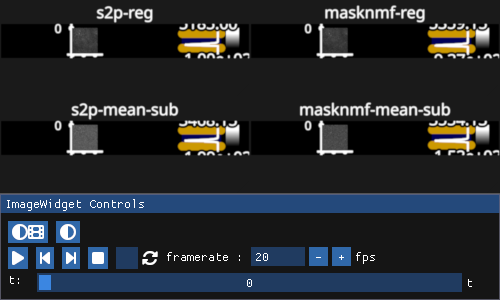

Draw error: Validation Error (3)


In [24]:
iw = fpl.ImageWidget(
    data = [data_reg, dense_moco, mean_sub, mean_sub_dense],
    names = ['s2p-reg', 'masknmf-reg', 's2p-mean-sub', 'masknmf-mean-sub'],
    figure_shape=(2, 2),
    cmap="gray",
)
iw.show()

In [25]:
iw.close()

In [ ]:
np.savez("pmd_reg_subfov.npz", pmd_obj)

In [31]:
pmd_obj_s2p = masknmf.compression.pmd_decomposition(
    data_reg, [32, 32],
    data_reg.shape[0],
    max_components = 10,
    background_rank = 10,
    device = "cpu"
)

pmd_obj_nmf = masknmf.compression.pmd_decomposition(
    dense_moco, [32, 32],
    dense_moco.shape[0],
    max_components = 10,
    background_rank = 10,
    device = "cpu"
)

[25-05-14 14:02:43]: Starting compression
[25-05-14 14:02:43]: sampled from the following regions: [0]
[25-05-14 14:02:43]: We are initializing on a total of 903 frames
[25-05-14 14:02:44]: Approximating full FOV basis terms
[25-05-14 14:02:44]: Loading data to estimate complete spatial basis
[25-05-14 14:02:44]: Finding spatiotemporal roughness thresholds


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:01<00:00, 191.93it/s]

[25-05-14 14:02:45]: Running Blockwise Decompositions


[25-05-14 14:02:48]: Constructed U matrix. Rank of U is 2101
[25-05-14 14:02:48]: PMD Objected constructed
[25-05-14 14:02:48]: Starting compression
[25-05-14 14:02:48]: sampled from the following regions: [0]
[25-05-14 14:02:48]: We are initializing on a total of 903 frames
[25-05-14 14:02:49]: Approximating full FOV basis terms
[25-05-14 14:02:49]: Loading data to estimate complete spatial basis
[25-05-14 14:02:49]: Finding spatiotemporal roughness thresholds


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:01<00:00, 200.07it/s]

[25-05-14 14:02:50]: Running Blockwise Decompositions


[25-05-14 14:02:53]: Constructed U matrix. Rank of U is 2179
[25-05-14 14:02:53]: PMD Objected constructed


RFBOutputContext()

C:\Users\RBO\repos\masknmf-toolbox\.venv\Lib\site-packages\fastplotlib\graphics\_features\_base.py:18: UserWarning: casting float64 array to float32
  warn(f"casting {array.dtype} array to float32")


JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
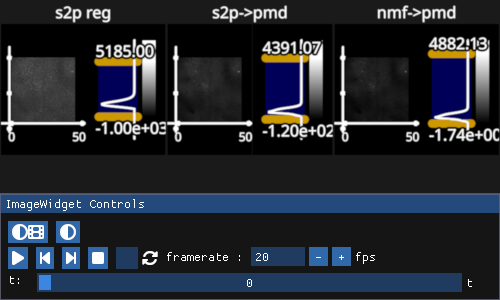

Draw error: Validation Error (6)


In [33]:
iw = fpl.ImageWidget(
    data = [data_reg, pmd_obj_s2p, pmd_obj_nmf],
    names = ['s2p reg', 's2p->pmd', 'nmf->pmd'],
    figure_shape=(1,3),
    cmap="gray",
)
iw.show()

In [34]:
iw.close()

In [35]:
num_frames, fov_dim1, fov_dim2 = pmd_obj_nmf.shape
device = 'cuda'
pmd_demixer = masknmf.demixing.signal_demixer.SignalDemixer(
    pmd_obj_nmf,
    device=device,
    frame_batch_size=100
)

Computing correlation data structure with MAD threshold  1and the robust corr term is 1
find superpixels!
find pure superpixels!
prepare iteration!


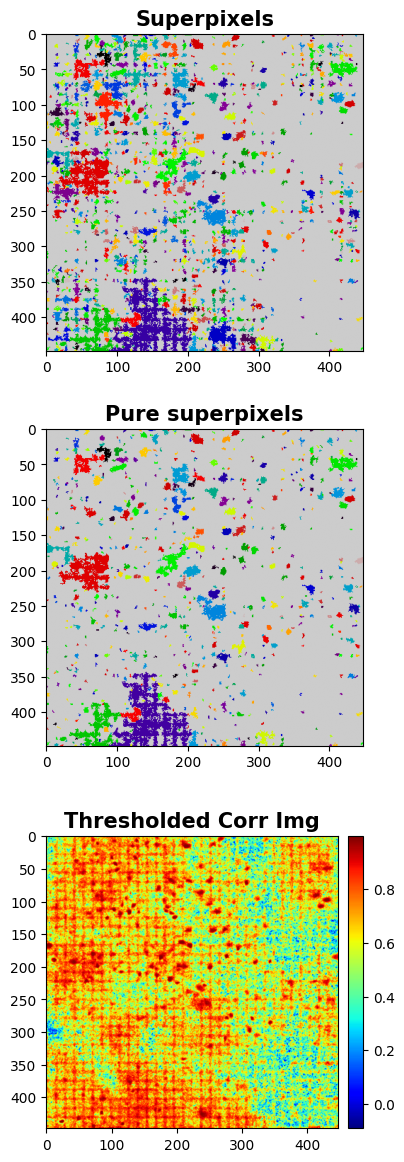

Identified 711 neurons here


In [36]:
init_kwargs = {
    #Worth modifying
    'mad_correlation_threshold':0.85,

    #Mostly stable
    'min_superpixel_size':5,
    'robust_corr_term':1,
    'mad_threshold':1,
    'residual_threshold': 0.3,
    'patch_size':(40, 40),
    'plot_en':True,
    'text':False,
}

pmd_demixer.initialize_signals(**init_kwargs, is_custom = False)
print(f"Identified {pmd_demixer.results[0].shape[1]} neurons here")

In [ ]:
print(pmd_demixer.state.state_description)

In [ ]:
pmd_demixer.lock_results_and_continue()

In [ ]:
## Demixing State

num_iters = 25
## Now run demixing...
localnmf_params = {
    'maxiter':num_iters,
    'support_threshold':np.linspace(0.95, 0.8, num_iters).tolist(),
    'deletion_threshold':0.2,
    'ring_model_start_pt': 4,
    'ring_radius':10,
    'merge_threshold':0.8,
    'merge_overlap_threshold':0.8,
    'update_frequency':4,
    'c_nonneg':True,
    'denoise':False,
    'plot_en': True
}

start_time = time.time()
with torch.no_grad():
    pmd_demixer.demix(**localnmf_params)
print(f"that took {time.time() - start_time}")
print(f"after this step {pmd_demixer.results.a.shape[1]} signals identified")

In [ ]:
# If desired, you can view the demixing results at this stage
iw = masknmf.visualization.make_demixing_video(
    pmd_demixer.results,
    device,
    show_histogram = True,
    v_range = [-100, 300],
)

iw.show()

In [ ]:
iw.close()

In [ ]:
# Move to next stage demixing
pmd_demixer.lock_results_and_continue(carry_background=True)

In [ ]:
print(pmd_demixer.state.state_description)

In [ ]:
init_kwargs = {
    #Worth modifying
    'mad_correlation_threshold':0.9,
    'min_superpixel_size':5,
    'robust_corr_term':1,

    #Mostly stable
    'mad_threshold':0,
    'residual_threshold': 0.3,
    'patch_size':(40, 40),
    'plot_en':True,
    'text':False,
}

pmd_demixer.initialize_signals(**init_kwargs, is_custom = False)
print(f"Identified {pmd_demixer.results[0].shape[1]} neurons here")

In [ ]:
# Move to next stage demixing
pmd_demixer.lock_results_and_continue(carry_background=True)

In [ ]:
## Demixing State
num_iters = 25
## Now run demixing...
localnmf_params = {
    'maxiter':num_iters,
    'support_threshold':np.linspace(0.95, 0.8, num_iters).tolist(),
    'deletion_threshold':0.2,
    'ring_model_start_pt': 4,
    'ring_radius':10,
    'merge_threshold':0.8,
    'merge_overlap_threshold':0.8,
    'update_frequency':4,
    'c_nonneg':True,
    'denoise':False,
    'plot_en': True
}

start_time = time.time()
with torch.no_grad():
    pmd_demixer.demix(**localnmf_params)
print(f"that took {time.time() - start_time}")
print(f"after this step {pmd_demixer.results.a.shape[1]} signals identified")



In [ ]:
a = pmd_demixer.results.ac_array.export_a()
c = pmd_demixer.results.ac_array.export_c()

#"a" is a fov dim1 x fov dim2 x number of neurons numpy.ndarray
#"c" is a num_frames x num_neurons np.ndarray

In [ ]:
np.savez("./pmg_obj.npz", pmd_obj)

In [ ]:
c.shape

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

def plot_pmd_projection(proj, a, savepath=None, fig_label=None, vmin=None, vmax=None, add_scalebar=False, dx=2.0):
    """
    Plot PMD projection with ROIs overlaid similarly to Suite2p plot_projection.
    
    Parameters
    ----------
    proj : np.ndarray
        Background image (mean or max projection), shape (Ly, Lx).
    a : np.ndarray
        Spatial components, shape (Ly, Lx, n_rois).
    savepath : Path or None
        Where to save the image (optional).
    fig_label : str or None
        Optional label for the figure.
    vmin, vmax : float
        Contrast limits for the projection.
    add_scalebar : bool
        Add a scale bar to the plot.
    dx : float
        Microns per pixel.
    """
    shape = proj.shape
    fig, ax = plt.subplots(figsize=(6, 6), facecolor='black')

    vmin = np.nanpercentile(proj, 2) 
    vmax = np.nanpercentile(proj, 98) if vmax is none else vmax
    if vmax - vmin < 1e-6:
        vmax = vmin + 1e-6

    ax.imshow(proj, cmap='gray', vmin=vmin, vmax=vmax)
    masks = np.nanmax(a, axis=-1)
    overlay = np.zeros((*shape, 4), dtype=np.float32)
    overlay[..., 1] = 1 
    overlay[..., 3] = (masks > 0) * 1.0 
    ax.imshow(overlay)

    ax.set_xticks([])
    ax.set_yticks([])
    if fig_label:
        fig_label = fig_label.replace("_", " ").replace("-", " ").replace(".", " ")
        ax.set_ylabel(fig_label, color='white', fontweight='bold', fontsize=12)

    if add_scalebar:
        scale_bar_length = 100 / dx
        scalebar_x = shape[1] * 0.05
        scalebar_y = shape[0] * 0.90
        ax.add_patch(Rectangle((scalebar_x, scalebar_y), scale_bar_length, 5,
                               edgecolor='white', facecolor='white'))
        ax.text(scalebar_x + scale_bar_length / 2, scalebar_y - 10,
                "100 μm", color='white', fontsize=10, ha='center', fontweight='bold')

    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    if savepath:
        savepath.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(savepath, dpi=300, facecolor='black')
        plt.close(fig)
    else:
        plt.show()


In [ ]:
mean_img = np.mean(data, axis=0)  # or use a registered mean if available

In [ ]:
plot_pmd_projection(mean_img, a, dx=2.0)